baseline.ipynb <br>
.. ├ models <br>
.. └ data <br>
.... ├ train_sdf <br>
.... ├ dev_sdf <br>
.... ├ test_sdf <br>
.... ├ train_imgs <br>
.... ├ test_imgs <br>
.... ├ sample_train.csv <br>
.... ├ sample_test.csv <br>
.... └ sample_submission.csv <br>

## 사용 패키지

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import rdkit

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
from tqdm import tqdm

import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, ConcatDataset

from sklearn.model_selection import train_test_split

import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torch.nn import functional as F
import random

from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose, Blur
    )
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import warnings
warnings.filterwarnings('ignore')

from torch_poly_lr_decay import PolynomialLRDecay
from alphafold2_pytorch import Alphafold2

In [2]:
print('numpy verison :', np.__version__)
print('pandas version :', pd.__version__)
print('opencv version :', cv2.__version__)
print('rdkit version :', rdkit.__version__)
print('torch version :', torch.__version__)

numpy verison : 1.19.2
pandas version : 1.1.5
opencv version : 4.5.3
rdkit version : 2021.03.4
torch version : 1.7.1


## 데이터 로드

In [3]:
train = pd.read_csv('/home/ubuntu/Samsung_Dacon/train2.csv')
dev = pd.read_csv('/home/ubuntu/Samsung_Dacon/dev.csv')

## 하이퍼파라미터

In [4]:
device = torch.device("cuda")
BATCH_SIZE = 356
EPOCHS = 400
num_layers = 1
dropout_rate = 0.1
atten_dim = 128
embedding_dim = 256
learning_rate = 1e-3
vision_pretrain = True
save_path = f'/home/ubuntu/Samsung_Dacon/models/EFB1_test.pt'

# best : tf_efficientnet_b1 / AdamW / Lr : 1e-6

## SMILES Tokenizing

In [5]:
class SMILES_Tokenizer():
    def __init__(self, max_length):
        self.txt2idx = {}
        self.idx2txt = {}
        self.max_length = max_length
    
    def fit(self, SMILES_list):
        unique_char = set()
        for smiles in SMILES_list:
            for char in smiles:
                unique_char.add(char)
        unique_char = sorted(list(unique_char))
        for i, char in enumerate(unique_char):
            self.txt2idx[char]=i+2
            self.idx2txt[i+2]=char
            
    def txt2seq(self, texts):
        seqs = []
        for text in tqdm(texts):
            seq = [0]*self.max_length
            for i, t in enumerate(text):
                if i == self.max_length:
                    break
                try:
                    seq[i] = self.txt2idx[t]
                except:
                    seq[i] = 1
            seqs.append(seq)
        return np.array(seqs)

In [6]:
max_len = train.SMILES.str.len().max()
max_len
tokenizer = SMILES_Tokenizer(max_len)
tokenizer.fit(train.SMILES)

In [7]:
seqs = tokenizer.txt2seq(train.SMILES)
labels = train[['Gap']].to_numpy()
imgs = ('/home/ubuntu/Samsung_Dacon/train_imgs/'+train.uid+'.png').to_numpy()

100%|██████████| 30274/30274 [00:00<00:00, 48247.94it/s]


## 학습 데이터셋

In [8]:
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

imgs, seqs, labels = shuffle(imgs, seqs, labels, random_state=42)

train_imgs = imgs[:27000]
train_seqs = seqs[:27000]
train_labels = labels[:27000]

val_imgs = imgs[27000:]
val_seqs = seqs[27000:]
val_labels = labels[27000:]

train_imgs.shape, train_seqs.shape, train_labels.shape, val_imgs.shape, val_seqs.shape, val_labels.shape

((27000,), (27000, 265), (27000, 1), (3274,), (3274, 265), (3274, 1))

In [9]:
import random
import os

def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_torch(seed=42)

In [10]:
class CustomDataset(Dataset):
    def __init__(self, imgs, seqs, labels=None, mode='train', transform=None, preprocessing=None):
        self.mode = mode
        self.imgs = imgs
        self.seqs = seqs
        if self.mode=='train':
            self.labels = labels
        self.transform = transform
        self.preprocessing = preprocessing
            
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, i):
        img = cv2.imread(self.imgs[i]).astype(np.float32)/255
        img = np.transpose(img, (2,0,1))
        if self.transform:
            augmented = self.transform(image=img)
            img = augmented['image']
        if self.preprocessing:
            pr = self.preprocessing(image=img)
            img = pr['image']
        
        if self.mode == 'train':
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'seq' : torch.tensor(self.seqs[i], dtype=torch.long),
                'label' : torch.tensor(self.labels[i], dtype=torch.float32)
            }
        else:
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'seq' : torch.tensor(self.seqs[i], dtype=torch.long),
            }

In [11]:
def get_training_augmentation(y=299,x=299):
    return A.Compose([
        A.Resize(y,x),
        A.HorizontalFlip(p=0.5),
#         A.VerticalFlip(p=0.5),
        A.Rotate(90)
        ])


formatted_settings = {
            'input_size': [3, 300, 300],
            'input_range': [0, 1]
}
def preprocess_input(
    x, mean=None, std=None, input_space="RGB", input_range=None, **kwargs
):

    if input_space == "BGR":
        x = x[..., ::-1].copy()

    if input_range is not None:
        if x.max() > 1 and input_range[1] == 1:
            x = x / 255.0

    if mean is not None:
        mean = np.array(mean)
        x = x - mean

    if std is not None:
        std = np.array(std)
        x = x / std

    return x

def get_preprocessing(preprocessing_fn):
    _transform = [
#         A.Lambda(image=preprocessing_fn),
#         A.Lambda(image=to_tensor, mask=to_tensor),
#         ToTensorV2
    ]
    return A.Compose(_transform)

def get_validation_augmentation(y=299,x=299):
    return A.Compose([
        A.Resize(y,x),
        A.HorizontalFlip(p=0.5),
#         A.VerticalFlip(p=0.5),
        A.Rotate(90)
        ])

def to_tensor(x, **kwargs):
    """
    Convert image or mask.
    """
    return x.transpose(2, 0, 1).astype('float32')

def norm(img):
    img-=img.min()
    return img/img.max()

In [12]:
import functools

preprocessing_fn = functools.partial(preprocess_input, **formatted_settings)
train_dataset = CustomDataset(train_imgs, train_seqs, train_labels,
                              transform=get_training_augmentation(),
                             preprocessing=get_preprocessing(preprocessing_fn)
                             )
val_dataset = CustomDataset(val_imgs, val_seqs, val_labels,
                           transform=get_validation_augmentation(),
                           preprocessing=get_preprocessing(preprocessing_fn)
                           )

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=BATCH_SIZE,
                                               num_workers=12,
                                               shuffle=True,
                                               pin_memory=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=BATCH_SIZE,
                                             num_workers=12,
                                             shuffle=False,
                                             pin_memory=True)

In [ ]:
sample_batch = next(iter(train_dataloader))
sample_batch['img'].size(), sample_batch['seq'].size(), sample_batch['label'].size()
sample_batch['img'].dtype, sample_batch['seq'].dtype, sample_batch['label'].dtype

# 모델

- EfficientNet에 LSTM을 연결한 CNN2RNN 모델

### EfficientNet n_channels_dict
- B1 : 1280 / B2 : 1408 / B3 : 1536 / B4 : 1792 / B5 : 2048 / B6 : 2304 / B7 : 2560

In [ ]:
import timm

class CNN_Encoder(nn.Module):
    def __init__(self, embedding_dim, rate):
        super(CNN_Encoder, self).__init__()
        model = timm.create_model('tf_efficientnet_b1', pretrained=True)
        modules = list(model.children())[:-2]
        self.feature_extract_model = nn.Sequential(*modules)
        self.dropout1 = nn.Dropout(rate)
        self.fc = nn.Linear(1280, embedding_dim)
        # ResNetRs : 2048
        self.dropout2 = nn.Dropout(rate)
        
    def forward(self, x):
        x = self.feature_extract_model(x)
        x = x.permute(0,2,3,1)
        x = x.view(x.size(0), -1, x.size(3))
        x = self.dropout1(x)
        x = nn.ReLU()(self.fc(x))
        x = self.dropout2(x)
        return x

In [ ]:
import re
import math
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

from torch.nn.utils.rnn import pad_packed_sequence

# Version 1 : Bi-LSTM * 2 

In [ ]:
class RNN_Decoder(nn.Module):
    def __init__(self, max_len, embedding_dim, num_layers, rate):
        super(RNN_Decoder, self).__init__()
        self.embedding = nn.Embedding(max_len, embedding_dim)
        self.dropout = nn.Dropout(rate)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        self.lstm1 = nn.LSTM(embedding_dim, embedding_dim, num_layers,
                             bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(embedding_dim*2, embedding_dim, num_layers,
                            bidirectional=True, batch_first=True)
        self.final_layer1 = nn.Linear(embedding_dim*2, embedding_dim*2)
        self.final_layer2 = nn.Linear(embedding_dim*2, embedding_dim*2)
        self.linear_global = nn.Linear(embedding_dim*2, 1)

    def forward(self, enc_out, dec_inp):
        with torch.no_grad():
            embedded = self.embedding(dec_inp)
        
        embedded = self.dropout(embedded)
        embedded = torch.cat([enc_out, embedded], dim=1)
        self.lstm1.flatten_parameters()
        hidden1, _ = self.lstm1(embedded)
        
        self.lstm2.flatten_parameters()
        hidden2, _ = self.lstm2(hidden1)
        
        h_conc_linear1 = F.relu(self.final_layer1(hidden1))
        h_conc_linear2 = F.relu(self.final_layer2(hidden2))
        
        
        hidden = hidden1 + hidden2 + h_conc_linear1 + h_conc_linear2
        
        
#         output = nn.ReLU()(self.final_layer(hidden))
        output = self.linear_global(hidden.mean(1))
#         output = hidden.mean(1)
        return output

# Version 2 : Bi-LSTM

In [17]:
class RNN_Decoder(nn.Module):
    def __init__(self, max_len, embedding_dim, num_layers, rate):
        super(RNN_Decoder, self).__init__()
        self.embedding = nn.Embedding(max_len, embedding_dim)
        self.dropout = nn.Dropout(rate)
        self.lstm = nn.LSTM(embedding_dim, embedding_dim, num_layers,
                             bidirectional=True, batch_first=True)
        self.linear_first = nn.Linear(2*embedding_dim, embedding_dim)
        self.linear_first.bias.data.fill_(0)
        self.linear_second = nn.Linear(embedding_dim, 1)
        self.linear_second.bias.data.fill_(0)
        
    def forward(self, enc_out, dec_inp):
        embedded = self.embedding(dec_inp)
        
        embedded = self.dropout(embedded)
        embedded = torch.cat([enc_out, embedded], dim=1)
#         self.lstm1.flatten_parameters()
        outputs, _ = self.lstm(embedded)
        
        outputs = outputs[:,-1,:]
        outputs = torch.flatten(outputs, 1)
        outputs = F.tanh(self.linear_first(outputs))
        outputs = self.linear_second(outputs)
        
        return outputs

In [ ]:
class CNN2RNN(nn.Module):
    def __init__(self, embedding_dim, max_len, num_layers, rate):
        super(CNN2RNN, self).__init__()
        self.cnn = CNN_Encoder(embedding_dim, rate)
        self.rnn = RNN_Decoder(max_len, embedding_dim, num_layers, rate)
        
    def forward(self, img, seq):
        cnn_output = self.cnn(img)
        output = self.rnn(cnn_output, seq)
        
        return output

In [ ]:
model = CNN2RNN(embedding_dim=embedding_dim, max_len=max_len, num_layers=num_layers, rate=dropout_rate)
model = nn.DataParallel(model)
model = model.to(device)

## 학습 정의

In [ ]:
# from adamp import AdamP

# # define your params
# optimizer = AdamP(model.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=1e-5)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)
criterion1 = nn.SmoothL1Loss()
criterion2 = nn.L1Loss()

In [ ]:
scaler = torch.cuda.amp.GradScaler()

def train_step(batch_item, epoch, batch, training):
    img = batch_item['img'].to(device)
    seq = batch_item['seq'].to(device)
    label = batch_item['label'].to(device)
    if training is True:
        model.train()

        optimizer.zero_grad()
        output = model(img, seq)
        
        with torch.cuda.amp.autocast():
#             loss1 = criterion1(output, label)
            loss = criterion2(output, label)
#             loss = loss1 + loss2
#             loss = 0.7*loss1 + 0.3*loss2

        scaler.scale(loss).backward()  
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5) 
        scaler.step(optimizer)
        scaler.update()

        scheduler.step()
        
        return loss

    else:
        model.eval()
        with torch.no_grad():
            output = model(img, seq)
#             loss1 = criterion1(output, label)
            loss = criterion2(output, label)
#             loss = loss1 + loss2
#             loss = 0.7*loss1 + 0.3*loss2
            
        return loss

## 학습

In [ ]:
dataset = ConcatDataset([train_dataset, val_dataset])

In [ ]:
# loss_plot, val_loss_plot = [], []

# from sklearn.model_selection import KFold
# kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# best_models = []
# for fold, (trn_idx, val_idx) in enumerate(kfold.split(dataset)):
#     print(f'[fold: {fold}]')
    
#     torch.cuda.empty_cache()
    
#     train_sampler = SubsetRandomSampler(trn_idx)
#     val_sampler = SubsetRandomSampler(val_idx)
    
    
#     train_dataloader = torch.utils.data.DataLoader(dataset,
#                                                batch_size=BATCH_SIZE,
#                                                num_workers=12,
#                                                 pin_memory=True,
#                                                 sampler=train_sampler)
#     val_dataloader = torch.utils.data.DataLoader(dataset,
#                                              batch_size=BATCH_SIZE,
#                                              num_workers=12,
#                                                 pin_memory=True,
#                                                 sampler=val_sampler)
    
#     for epoch in range(EPOCHS):
#         total_loss, total_val_loss = 0, 0

#         tqdm_dataset = tqdm(enumerate(train_dataloader))
#         training = True
#         for batch, batch_item in tqdm_dataset:
#             batch_loss = train_step(batch_item, epoch, batch, training)
#             total_loss += batch_loss

#             tqdm_dataset.set_postfix({
#                 'Fold': fold + 1,
#                 'Epoch': epoch + 1,
#                 'Loss': '{:06f}'.format(batch_loss.detach()),
#                 'Total Loss' : '{:06f}'.format(total_loss/(batch+1))
#             })
#         loss_plot.append(total_loss/(batch+1))

#         tqdm_dataset = tqdm(enumerate(val_dataloader))
#         training = False
#         for batch, batch_item in tqdm_dataset:
#             batch_loss = train_step(batch_item, epoch, batch, training)
#             total_val_loss += batch_loss

#             tqdm_dataset.set_postfix({
#                 'Fold': fold + 1,
#                 'Epoch': epoch + 1,
#                 'Val Loss': '{:06f}'.format(batch_loss.detach()),
#                 'Total Val Loss' : '{:06f}'.format(total_val_loss/(batch+1))
#             })
#         val_loss_plot.append(total_val_loss/(batch+1))

#         if np.min(val_loss_plot) == val_loss_plot[-1]:
#     #         torch.save(model, save_path)
#             torch.save({'state_dict': model.state_dict()}, '/home/ubuntu/Samsung_Dacon/models/Tf_EfficientB1/tf_efficientnet_b1-fold{}.pt'.format(fold))
# #             torch.save({'state_dict': model.state_dict()}, save_path)

In [ ]:
loss_plot, val_loss_plot = [], []

for epoch in range(EPOCHS):
    total_loss, total_val_loss = 0, 0

    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_loss = train_step(batch_item, epoch, batch, training)
        total_loss += batch_loss

        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(batch_loss.detach()),
            'Total Loss' : '{:06f}'.format(total_loss/(batch+1))
        })
    loss_plot.append(total_loss/(batch+1))

    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_loss = train_step(batch_item, epoch, batch, training)
        total_val_loss += batch_loss

        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.detach()),
            'Total Val Loss' : '{:06f}'.format(total_val_loss/(batch+1))
        })
    val_loss_plot.append(total_val_loss/(batch+1))

    if np.min(val_loss_plot) == val_loss_plot[-1]:
#         torch.save(model, save_path)
#             torch.save({'state_dict': model.state_dict()}, '/home/ubuntu/Samsung_Dacon/models/Tf_EfficientB1/tf_efficientnet_b1-fold{}.pt'.format(fold))
        torch.save({'state_dict': model.state_dict()}, save_path)

## 학습 결과

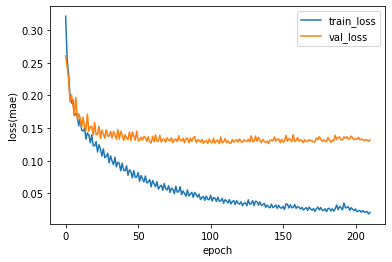

In [24]:
plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss(mae)')
plt.legend()
plt.show()

## 모델 복원

In [25]:
# model = CNN2RNN(embedding_dim=embedding_dim, max_len=max_len, num_layers=num_layers, rate=dropout_rate)
# model = nn.DataParallel(model)
# model = model.to(device)

# import copy
# best_models=[]
# save_path = f'/home/ubuntu/Samsung_Dacon/models/Tf_EfficientB1/tf_efficientnet_b1-fold1.pt'
# checkpoint = torch.load(save_path)
# model.load_state_dict(checkpoint['state_dict'])
# best_models.append(copy.deepcopy(model))

# save_path2 = f'/home/ubuntu/Samsung_Dacon/models/Tf_EfficientB1/tf_efficientnet_b1-fold2.pt'
# checkpoint = torch.load(save_path2)
# model.load_state_dict(checkpoint['state_dict'])
# best_models.append(copy.deepcopy(model))

# save_path3 = f'/home/ubuntu/Samsung_Dacon/models/Tf_EfficientB1/tf_efficientnet_b1-fold3.pt'
# checkpoint = torch.load(save_path3)
# model.load_state_dict(checkpoint['state_dict'])
# best_models.append(copy.deepcopy(model))

# save_path4 = f'/home/ubuntu/Samsung_Dacon/models/Tf_EfficientB1/tf_efficientnet_b1-fold4.pt'
# checkpoint = torch.load(save_path4)
# model.load_state_dict(checkpoint['state_dict'])
# best_models.append(copy.deepcopy(model))

In [26]:
# save_path = f'/home/ubuntu/Samsung_Dacon/models/Tf_EfficientB1/tf_efficientnet_b1-fold4.pt'
checkpoint = torch.load(save_path)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

## 테스트 데이터 및 제출 양식 로드

In [27]:
test = pd.read_csv('/home/ubuntu/Samsung_Dacon/test.csv')
submission = pd.read_csv('/home/ubuntu/Samsung_Dacon/sample_submission.csv')

## 테스트 데이터 전처리

In [28]:
# for idx, row in tqdm(test.iterrows()):
#     file = row['uid']
#     smiles = row['SMILES']
#     m = Chem.MolFromSmiles(smiles)
#     if m != None:
#         img = Draw.MolToImage(m, size=(300,300))
#         img.save(f'/home/ubuntu/Samsung_Dacon/test_imgs/{file}.png')

## 테스트 데이터셋

In [29]:
test_seqs = tokenizer.txt2seq(test.SMILES)
test_imgs = ('/home/ubuntu/Samsung_Dacon/test_imgs/'+test.uid+'.png').to_numpy()

100%|██████████| 602/602 [00:00<00:00, 42184.80it/s]


In [30]:
test_dataset = CustomDataset(imgs=test_imgs,
                             seqs=test_seqs,
                             labels=None, mode='test',
                            transform=get_validation_augmentation(),
                           preprocessing=get_preprocessing(preprocessing_fn)
                            )

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=BATCH_SIZE,
                                              num_workers=12,
                                             pin_memory=True,
                                             shuffle=False)

In [31]:
# test_dataset1 = CustomDataset(imgs=test_imgs,
#                              seqs=test_seqs,
#                              labels=None, mode='test',
#                             transform=None,
#                           preprocessing=get_preprocessing(preprocessing_fn)
#                             )

# test_dataloader1 = torch.utils.data.DataLoader(test_dataset1,
#                                               batch_size=BATCH_SIZE,
#                                               num_workers=12,
#                                              pin_memory=True,
#                                              shuffle=False)

# test_dataset2 = CustomDataset(imgs=test_imgs,
#                              seqs=test_seqs,
#                              labels=None, mode='test',
#                             transform=get_validation_augmentation(),
#                            preprocessing=get_preprocessing(preprocessing_fn)
#                             )

# test_dataloader2 = torch.utils.data.DataLoader(test_dataset2,
#                                               batch_size=BATCH_SIZE,
#                                               num_workers=12,
#                                              pin_memory=True,
#                                              shuffle=False)

# test_dataset3 = CustomDataset(imgs=test_imgs,
#                              seqs=test_seqs,
#                              labels=None, mode='test',
#                             transform=get_validation_augmentation(),
#                            preprocessing=get_preprocessing(preprocessing_fn)
#                             )

# test_dataloader3 = torch.utils.data.DataLoader(test_dataset3,
#                                               batch_size=BATCH_SIZE,
#                                               num_workers=12,
#                                              pin_memory=True,
#                                              shuffle=False)

# test_dataset4 = CustomDataset(imgs=test_imgs,
#                              seqs=test_seqs,
#                              labels=None, mode='test',
#                             transform=get_validation_augmentation(),
#                            preprocessing=get_preprocessing(preprocessing_fn)
#                             )

# test_dataloader4 = torch.utils.data.DataLoader(test_dataset4,
#                                               batch_size=BATCH_SIZE,
#                                               num_workers=12,
#                                              pin_memory=True,
#                                              shuffle=False)

## 추론 및 제출

In [32]:
def predict(dataset):
    model.eval()
    result = []
    for batch_item in dataset:
        img = batch_item['img'].to(device)
        seq = batch_item['seq'].to(device)
        with torch.no_grad():
            output = model(img, seq)
        output = output.cpu().numpy()
#         gap = (output[:, 0] - output[:, 1]) # + output[:,2])/2.0
        gap = output[:,0]
        gap = np.where(gap<0, 0, gap)
        result.extend(list(gap))
        
    return result

In [33]:
# prediction_list=[]
# prediction_df = pd.read_csv('sample_submission.csv')

# for test_dataloader in [test_dataloader1, test_dataloader2, test_dataloader3, test_dataloader4]:
#     for model in best_models:
#         prediction_array = np.zeros([prediction_df.shape[0],
#                                 prediction_df.shape[1] -1])      
#         for idx, sample in enumerate(test_dataloader):
#             model.eval()
#             img = sample['img'].to(device)
#             seq = sample['seq'].to(device)
#             with torch.no_grad():
#                 probs = model(img, seq)
#             probs = probs.cpu().numpy()
#             gap = probs[:, 0]
#         prediction_list.append(gap)
# #             prediction_array[idx*BATCH_SIZE: (idx+1)*BATCH_SIZE,:]\
# #                       = gap.astype(np.float32)
                
# #         predictions_list.append(prediction_array[...,np.newaxis])

# # # axis = 2를 기준으로 평균 (TTA, folds for each SEED)
# # predictions_array = np.concatenate(predictions_list, axis = 2)
# # predictions_mean = predictions_array.mean(axis = 2)

# # # 평균 값이 0.5보다 클 경우 1 작으면 0
# # predictions_mean = (predictions_mean > 0.5) * 1
# # predictions_mean

In [34]:
pred = predict(test_dataloader)

In [35]:
submission['ST1_GAP(eV)'] = pred

In [36]:
submission

,uid,ST1_GAP(eV)
0,test_0,0.782390
1,test_1,2.250865
2,test_2,0.899378
3,test_3,0.595134
4,test_4,1.230900
...,...,...
597,test_597,0.124859
598,test_598,0.000000
599,test_599,0.031120
600,test_600,0.010209


In [37]:
submission.to_csv('dacon_baseline.csv', index=False)

제출 API 사용법 => https://dacon.io/forum/403557

In [ ]:
# from dacon_submit_api import dacon_submit_api 

# result = dacon_submit_api.post_submission_file(
#     '/home/ubuntu/Samsung_Dacon/dacon_baseline.csv', 
#     '19342bef1dc6b917ad92a59c02df55db3395fcbe58c0ccdc5eb5761d9a27d5f7', 
#     '235789', 
#     '', 
#     'DACON_Baseline'
# )

# Public LB Score : 0.1871130054